In [ ]:
! pip install ONE-api
! pip install ibllib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.3/993.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 12.7 MB/s eta 

In [1]:
from one.api import ONE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from brainbox.io.one import SpikeSortingLoader
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves

In [2]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [ ]:
# Find sessions with complete wheel and spike data (unused)
eids = one.search(project='ibl_neuropixel_brainwide_01',
                 datasets=['spikes.times.npy','_ibl_wheel.position.npy'])
print(f"Found {len(eids)} valid sessions")

# Old Functions
def get_wheel_velos(eid):
    wheel = one.load_object(eid, 'wheel', collection='alf')
    pos = wheel['position']
    ts = wheel['timestamps']
    # Compute velocity using central differences
    vel = np.gradient(pos, ts)

    # Resample to match neural data bins
    bins = np.arange(ts[0], ts[-1], bin_size)
    vel_binned = np.interp(bins, ts, vel)
    return bins, vel_binned

def select_features(spike_counts, clusters,cluster_id ,threshold=0.5): # Increased threshold
    # Filter based on firing rate stability
    fr_mean = spike_counts.mean(0)
    fr_std = spike_counts.std(0)
    stable_units = (fr_std / (fr_mean + 1e-6)) < threshold
    print(f"Found {np.sum(stable_units)} stable units")
    clusters_df = pd.DataFrame(clusters)
    # Ensure at least one feature is selected:
    if np.sum(stable_units) == 0:
        stable_units = np.ones_like(stable_units, dtype=bool) # Select all if none are stable
        print("Warning: No stable units found, using all units for decoding.")
    return spike_counts[:, stable_units],  clusters_df.iloc[cluster_id[0].tolist()][stable_units]

def align_data(neural_times, neural_features, wheel_times, wheel_speed):
    from concurrent.futures import ThreadPoolExecutor
    # Find overlapping time window
    t_start = max(neural_times[0], wheel_times[0])
    t_end = min(neural_times[-1], wheel_times[-1])

    # Create common time basis
    common_time = np.arange(t_start, t_end, 0.02)

    # Interpolate both datasets
    """ 
    # Reshape neural_features to 1D if necessary
    if neural_features.ndim > 1:
        neural_features = neural_features.reshape(-1) # Reshape to 1D
    neural_aligned = np.interp(common_time, neural_times, neural_features)
     """
    # Parallelized interpolation
    neural_aligned = np.empty((len(common_time), neural_features.shape[1]))
    with ThreadPoolExecutor() as executor:
        futures = []
        for col in range(neural_features.shape[1]):
            futures.append(
                executor.submit(
                    np.interp,
                    common_time,
                    neural_times,
                    neural_features[:, col]
                )
            )
        for col, future in enumerate(futures):
            neural_aligned[:, col] = future.result()
    wheel_aligned = np.interp(common_time, wheel_times, wheel_speed)

    return common_time, neural_aligned, wheel_aligned

Found 483 valid sessions


In [3]:
def load_spike_features(eid, probe='probe00', bin_size=0.02):
    sl = SpikeSortingLoader(eid=eid, one=one,pname=probe)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    cluster_id = np.where(clusters['label'] == 1)
    print(f"Found {len(cluster_id[0])} clusters")

    # Convert to spike counts per time bin
    times = np.arange(spikes['times'].min(), spikes['times'].max(), bin_size)
    spike_counts = np.zeros((len(times)-1, len(cluster_id[0])))
    for i, cluster in enumerate(cluster_id[0]):
        cluster_spikes = spikes['times'][spikes['clusters'] == cluster]
        spike_counts[:,i], _ = np.histogram(cluster_spikes, bins=times)
    return times[:-1], spike_counts, clusters,cluster_id

In [4]:
def select_features(spike_counts, threshold=5, min_units=25):
    # Dynamic threshold adjustment
    fr_mean = spike_counts.mean(0)
    fr_std = spike_counts.std(0)
    stability = fr_std / (fr_mean + 1e-6)

    # Ensure minimum unit count
    valid_units = stability < threshold
    print(f"Found {np.sum(valid_units)} stable units")
    if np.sum(valid_units) < min_units:
        valid_units = stability < np.quantile(stability, min_units/len(stability))
        print(f"Need >={min_units} stable units, selected {np.sum(valid_units)} by best stability")

    return spike_counts[:, valid_units]


def normalize_data(spike_counts, wheel_velos, spike_mean=None, spike_std=None, wheel_mean=None):
    # Z-score inputs.
    if spike_mean is None:
        spike_mean = np.nanmean(spike_counts,axis=0)
    if spike_std is None:
        spike_std = np.nanstd(spike_counts,axis=0)
    spike_counts = (spike_counts - spike_mean) / spike_std

    # Zero-center outputs
    if wheel_mean is None:
        wheel_mean = np.mean(wheel_velos, axis=0)
    wheel_velos -= wheel_mean
    return spike_counts, wheel_velos, spike_mean, spike_std, wheel_mean

In [5]:
def align_data(neural_times, neural_features, wheel_times, wheel_velos):
    # Validate temporal overlap
    overlap_start, overlap_end = 0, neural_times.shape[0]
    if neural_times[0] < wheel_times[0]:
        overlap_start = np.where(neural_times >= wheel_times[0])[0][0]    # first timestamp bigger than wheel
    if neural_times[-1] > wheel_times[-1]:
        overlap_end = np.where(neural_times <= wheel_times[-1])[0][-1] + 1    # last timestamp smaller than wheel

    if overlap_start >= overlap_end:
        raise ValueError(
            f"No temporal overlap between neural ({neural_times[0]:.2f}-{neural_times[-1]:.2f}s) "
            f"and wheel ({wheel_times[0]:.2f}-{wheel_times[-1]:.2f}s) data"
        )

    # Unified timebase
    common_time = neural_times[overlap_start : overlap_end]
    neural_aligned = neural_features[overlap_start : overlap_end]
    wheel_aligned = np.interp(common_time, wheel_times, wheel_velos)

    return common_time, neural_aligned, wheel_aligned

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from tqdm import tqdm

class NeuralDecoderMLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, dropout=0.3):
        super().__init__()
        self.temporal_encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size//2),
            nn.LayerNorm(hidden_size//2),
            nn.ReLU()
        )
        self.temporal_context = nn.LSTM(hidden_size//2, hidden_size//4, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size//4, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.temporal_encoder(x)    # 256 x 15 x 128
        x, _ = self.temporal_context(x)    # 256 x 15 x 64
        x = self.regressor(x)    # 256 x 15 x 1
        return x.squeeze(-1)    # 256 x 15

def prepare_sequences(X, y, window=15):
    """Create temporal sequences for neural network input"""
    X_seq = np.zeros((len(X) - window, window, X.shape[1]))
    y_seq = np.zeros((len(X) - window, window))
    for i in range(len(X) - window):
        X_seq[i] = X[i : i + window]
        y_seq[i] = y[i : i + window]
    return X_seq, y_seq

def train_mlp_decoder(X, y, device='cuda', n_epochs=100):
    # Temporal sequence preparation
    X_seq, y_seq = prepare_sequences(X, y)

    # Train/val split preserving temporal order
    split = int(0.8*len(X_seq))
    X_train, X_val = X_seq[:split], X_seq[split:]
    y_train, y_val = y_seq[:split], y_seq[split:]

    # Convert to PyTorch tensors
    train_data = TensorDataset(torch.FloatTensor(X_train),
                              torch.FloatTensor(y_train))
    val_data = TensorDataset(torch.FloatTensor(X_val),
                            torch.FloatTensor(y_val))

    # Model configuration
    model = NeuralDecoderMLP(input_size=X.shape[1], hidden_size=256).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    loss_fn = nn.HuberLoss()

    # Training loop with early stopping
    best_val_r2 = -np.inf
    patience_counter = 0
    for epoch in tqdm(range(n_epochs), "Training"):
        model.train()
        train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device)).squeeze()
            loss = loss_fn(pred, y_batch.to(device))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_loader = DataLoader(val_data, batch_size=512)
            val_preds = []
            val_targets = []  # Accumulate true values as well

            for X_val_batch, y_val_batch in val_loader:
                pred = model(X_val_batch.to(device)).cpu().numpy().squeeze()
                val_preds.extend(pred)  # Use extend for adding individual items
                val_targets.extend(y_val_batch.cpu().numpy())  # Collect true values

            # Calculate R2 outside the loop on full arrays
            val_r2 = r2_score(val_targets, val_preds)

        # Early stopping
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 10:
            break
    
    return model, best_val_r2

In [ ]:
if __name__ == "__main__":
    # Modified main analysis loop
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for eid in eids[:1]:
        # try:
            # Data loading (same as before)
            neural_times, spike_counts, clusters,cluster_id = load_spike_features(eid)
            wheel_data = one.load_object(eid, 'wheel', collection='alf')
            wheel_velos = np.gradient(wheel_data["position"], wheel_data["timestamps"])

            # Feature selection and alignment
            stable_spikes = select_features(spike_counts)
            norm_spikes, wheel_velos, spike_mean, spike_std, wheel_mean = normalize_data(stable_spikes, wheel_velos)
            common_time, X_aligned, y_aligned = align_data(neural_times, norm_spikes, wheel_data["timestamps"], wheel_velos)

            # Train MLP decoder
            model, best_val_r2 = train_mlp_decoder(X_aligned, y_aligned, device=device)
            print(f"Session {eid} achieved Validation R²={best_val_r2:.3f}")

            # Full sequence prediction
            X_full, y_full = prepare_sequences(X_aligned, y_aligned)
            with torch.no_grad():
                full_pred = model(torch.FloatTensor(X_full).to(device)).cpu().numpy()

            # Visualization with temporal offset
            plt.figure(figsize=(12,4))
            plt.plot(common_time[15:], y_full, label='Actual Speed')
            plt.plot(common_time[15:], full_pred, label='MLP Prediction')
            plt.xlabel('Time (s)')
            plt.ylabel('Wheel Speed (cm/s)')
            plt.legend()
            plt.title(f'MLP Decoding Performance - {eid}')
            plt.show()

        # except Exception as e:
        #     print(f"Error processing {eid}: {str(e)}")

In [7]:
eid = "c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9"
neural_times, spike_counts, clusters,cluster_id = load_spike_features(eid)
wheel_data = one.load_object(eid, 'wheel', collection='alf')
wheel_velos = np.gradient(wheel_data["position"], wheel_data["timestamps"])

# Feature selection and alignment
stable_spikes = select_features(spike_counts)
norm_spikes, wheel_velos, spike_mean, spike_std, wheel_mean = normalize_data(stable_spikes, wheel_velos)
common_time, X_aligned, y_aligned = align_data(neural_times, norm_spikes, wheel_data["timestamps"], wheel_velos)

Found 154 clusters
Found 25 stable units


In [12]:
model, best_val_r2 = train_mlp_decoder(X_aligned, y_aligned, device="cuda")
print(f"Session {eid} achieved Validation R²={best_val_r2:.3f}")

Training:  13%|█▎        | 13/100 [02:42<18:08, 12.51s/it]

Session c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9 achieved Validation R²=0.027


<ErrorbarContainer object of 3 artists>

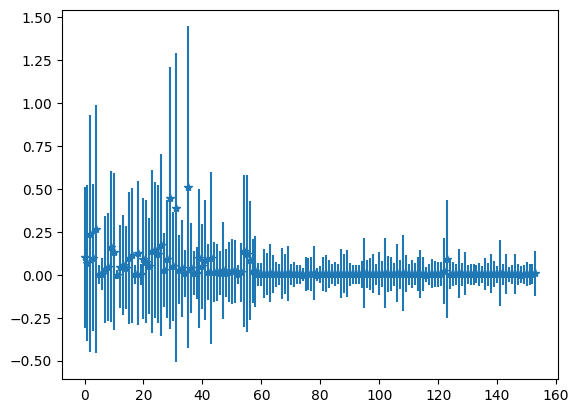

In [44]:
fr_mean = spike_counts.mean(0)
fr_std = spike_counts.std(0)

plt.errorbar(np.arange(len(fr_mean)), fr_mean, fr_std, linestyle="None", marker="*")